<a href="https://colab.research.google.com/github/tmathema/Employee_reviews_NLP/blob/main/BERT_model_for_classification_company_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  
drive.mount('/content/drive')  

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 7.4 MB/s 
     |████████████████████████████████| 163 kB 59.8 MB/s 
     |████████████████████████████████| 7.6 MB 50.7 MB/s 


In [ ]:
#confriming that the GPU was detected
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
#checking type of gpu
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd

In [ ]:
# uploading the data
X_data_balanced = pd.read_pickle("/content/drive/MyDrive/x_consulting/X_data_balanced.pkl")

In [ ]:
# uploading the data
y_data_balanced = pd.read_pickle("/content/drive/MyDrive/x_consulting/y_data_balanced.pkl")

In [ ]:
y_data = y_data_balanced.map({1:0, 2:1, 3:2, 4:3, 5:4})

In [ ]:
y_data = y_data.to_numpy().astype(int)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in X_data_balanced.text:
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} comments'.format(len(input_ids)))

Tokenizing comments...
  Read 0 comments.
  Read 20,000 comments.
  Read 40,000 comments.
  Read 60,000 comments.
  Read 80,000 comments.
  Read 100,000 comments.
  Read 120,000 comments.
  Read 140,000 comments.
  Read 160,000 comments.
  Read 180,000 comments.
  Read 200,000 comments.
  Read 220,000 comments.
  Read 240,000 comments.
DONE.
   259,385 comments


In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))
print('Mean length: {:,} tokens'.format(np.mean(lengths)))

   Min length: 9 tokens
   Max length: 360 tokens
Median length: 32.0 tokens
Mean length: 46.304065385430924 tokens


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras_preprocessing.sequence import pad_sequences

# Set the required sequence length.
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
import random
import numpy as np

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(input_ids))
val_size = int(0.1 * len(input_ids))
test_size = len(input_ids) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(input_ids))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(input_ids))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 207,508
Validation size: 25,938
      Test size: 25,939


In [ ]:
# Select the inputs for the different splits.
train_inputs = input_ids[train_idx]
validation_inputs = input_ids[val_idx]
test_inputs = input_ids[test_idx]

In [ ]:
# Select the inputs for the different splits.
train_labels = y_data[train_idx]
validation_labels = y_data[val_idx]
test_labels = y_data[test_idx]

In [ ]:
train_masks = [attention_masks[i] for i in train_idx]
validation_masks = [attention_masks[i] for i in val_idx]
test_masks = [attention_masks[i] for i in test_idx]

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Create the DataLoader for our validation set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
#normal BERT model with an added single linear layer on top for classification
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--5 for classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, consider changing to 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    predictions , true_labels = [], []
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
      # Tracking variables 

      
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)          
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    val_predictions , val_true_labels = [], []

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  6,485.    Elapsed: 0:00:34.
  Batch   200  of  6,485.    Elapsed: 0:01:08.
  Batch   300  of  6,485.    Elapsed: 0:01:43.
  Batch   400  of  6,485.    Elapsed: 0:02:16.
  Batch   500  of  6,485.    Elapsed: 0:02:51.
  Batch   600  of  6,485.    Elapsed: 0:03:25.
  Batch   700  of  6,485.    Elapsed: 0:03:59.
  Batch   800  of  6,485.    Elapsed: 0:04:33.
  Batch   900  of  6,485.    Elapsed: 0:05:07.
  Batch 1,000  of  6,485.    Elapsed: 0:05:41.
  Batch 1,100  of  6,485.    Elapsed: 0:06:15.
  Batch 1,200  of  6,485.    Elapsed: 0:06:49.
  Batch 1,300  of  6,485.    Elapsed: 0:07:23.
  Batch 1,400  of  6,485.    Elapsed: 0:07:57.
  Batch 1,500  of  6,485.    Elapsed: 0:08:31.
  Batch 1,600  of  6,485.    Elapsed: 0:09:05.
  Batch 1,700  of  6,485.    Elapsed: 0:09:39.
  Batch 1,800  of  6,485.    Elapsed: 0:10:13.
  Batch 1,900  of  6,485.    Elapsed: 0:10:47.
  Batch 2,000  of  6,485.    Elapsed: 0:11:21.
  Batch 2,100  of

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
gdrive_path = "./drive/My Drive/x_consulting/model_save/"

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/x_consulting/model_save/"

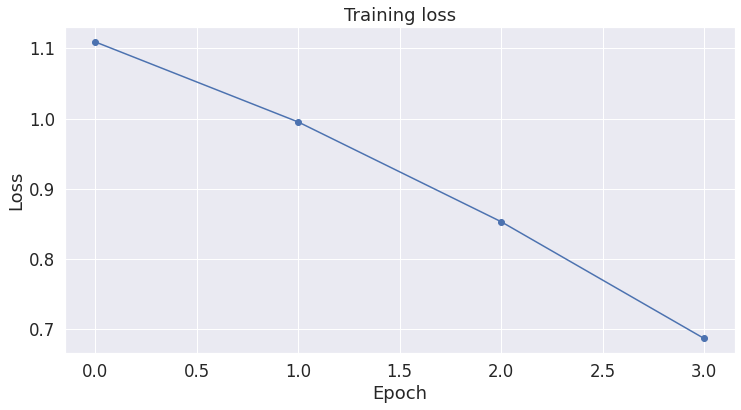

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 25,939 test sentences...
  Batch   100  of    811.    Elapsed: 0:00:11.
  Batch   200  of    811.    Elapsed: 0:00:22.
  Batch   300  of    811.    Elapsed: 0:00:34.
  Batch   400  of    811.    Elapsed: 0:00:45.
  Batch   500  of    811.    Elapsed: 0:00:56.
  Batch   600  of    811.    Elapsed: 0:01:07.
  Batch   700  of    811.    Elapsed: 0:01:18.
  Batch   800  of    811.    Elapsed: 0:01:30.
    DONE.


In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Take the highest scoring output as the predicted label.
predicted_labels = np.argmax(predictions, axis=1)

print('`predictions` has shape', predictions.shape)
print('`predicted_labels` has shape', predicted_labels.shape)

`predictions` has shape (25939, 5)
`predicted_labels` has shape (25939,)


In [ ]:
# Reduce printing precision for legibility.
np.set_printoptions(precision=2)

print("Predicted:", str(predicted_labels[0:10]))
print("  Correct:", str(true_labels[0:10]))

Predicted: [0 0 1 2 3 0 2 3 2 3]
  Correct: [0 0 2 1 3 1 2 2 2 2]


In [ ]:
predicted_labels = pd.DataFrame(predicted_labels)
true_labels = pd.DataFrame(true_labels)

In [ ]:
predicted_labels

,0
0,0
1,0
2,1
3,2
4,3
...,...
25934,0
25935,2
25936,4
25937,2


In [ ]:
predicted_labels.to_pickle("/content/drive/MyDrive/x_consulting/predicted_labels.pkl")
true_labels.to_pickle("/content/drive/MyDrive/x_consulting/true_labels.pkl")

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
cm

array([[3196, 1395,  365,   91,   84],
       [1200, 2430, 1187,  239,  105],
       [ 258, 1222, 2366, 1152,  331],
       [  47,  240, 1257, 2342, 1279],
       [  28,   60,  416, 1372, 3277]])

In [ ]:
import numpy as np
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [ ]:
recall = np.mean(recall)
precision = np.mean(precision)

print('Precision: ',precision)
print('Recall: ',recall)

Precision:  0.5299577898862913
Recall:  0.5254164149316871


In [ ]:
from sklearn import metrics

# Use the F1 metric to score our classifier's performance on the test set.
score = metrics.f1_score(true_labels, predicted_labels, average='macro')

# Print the F1 score!
print('F1 score: {:.3}'.format(score))

F1 score: 0.527
